# Сжатие языковой модели

## Порядок сдачи домашнего

Под каждое домашнее вы создаете отдельную ветку куда вносите все изменения в рамках домашнего. Как только домашнее готово - создаете пулл реквест (обратите внимание что в пулл реквесте должны быть отражены все изменения в рамках домашнего). Ревьювера назначаете из таблицы - https://docs.google.com/spreadsheets/d/1vK6IgEqaqXniUJAQOOspiL_tx3EYTSXW1cUrMHAZFr8/edit?gid=0#gid=0
Перед сдачей проверьте код, напишите тесты. Не забудьте про PEP8, например, с помощью flake8. Задание нужно делать в jupyter notebook.

**Дедлайн - 17 октбяря 10:00**

В этом домашнем задании вам предстоит изучить и реализовать комбинированный алгоритм для сжатия матриц весов языковой модели, который включает три этапа: 
- **Квантизацию**
- **Кодирование Хаффмана**
- **Бит-паккинг**
- **Запись и чтение в файл**

Вам также необходимо будет реализовать обратную процедуру расжатия для восстановления матрицы до её исходного состояния. Пакетом `numpy` пользовать нельзя.

Для начала сгенерируем нашу матрицу весов. Реализуйте функцию `generate_normal_weights_matrix`, которая будет генерировать матрицу случайных весов, где веса распределены нормально. Вам понадобится функция `random.gauss` для генерации случайных чисел из нормального распределения:

In [610]:
import random

mean = 0.0
stddev = 0.1
random.gauss(mean, stddev)

0.034262184475846356

```python
weights_matrix = generate_normal_weights_matrix(5, 5)
for row in weights_matrix:
    print(row)
[0.3000485326712691, 0.25965299191334695, -0.06755153631842248, 0.13020487844655038, 0.1143769419370928]
[0.04287032494033407, 0.37860865986969466, -0.21154587156719093, 0.02538857794887883, 0.358874552698265]
[-0.12730102686770312, -0.09250783210681686, -0.31943991155969786, -0.12649930568136855, -0.133368865014227]
[-0.001125940850390421, 0.08131363950833258, -0.12099869191945688, 0.14554258117597563, 0.157276907472140]
[-0.07352639207896368, 0.013629438616873364, -0.11502982664385775, 0.042140678513802377, 0.0980238501942050]
```

In [611]:
def generate_normal_weights_matrix(rows, cols, mean=0.0, stddev=0.1):
    return [[random.gauss(mean, stddev) for _ in range(cols)] for _ in range(rows)]

In [612]:
weights_matrix = generate_normal_weights_matrix(5, 5)
for row in weights_matrix:
    print(row)

[0.15089991323830054, -0.11606404041872792, 0.01115606466294082, 0.014188074224681239, -0.05776580377344877]
[0.09753178632665455, 0.002033543344529341, 0.1678560201786109, 0.09844799975016458, -0.1267630258627138]
[-0.010359365223641545, -0.0707515456087862, -0.02150973188462797, 0.11453110360106698, -0.18423707091130456]
[0.12189959385547758, 0.06542272952258463, -0.10567520641971535, 0.02655587771181311, 0.047989803116363534]
[0.13051170560548392, -0.07101670658579601, -0.01597694029712083, -0.13218470242579902, -0.13087037439499305]


Для упрощения работы переведем двух мерный массив в одномерный.

In [613]:
weights_matrix = generate_normal_weights_matrix(100, 100, mean, stddev)

In [614]:
weights = [weight for row in weights_matrix for weight in row]

Проверим, что у нас получилось.

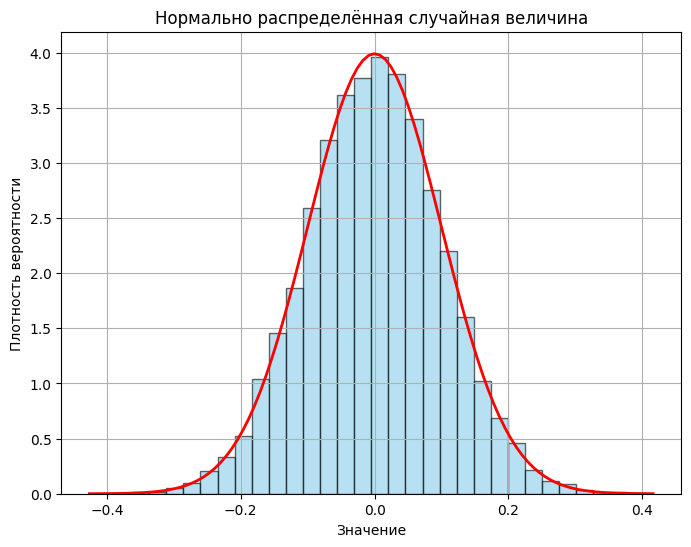

In [615]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.figure(figsize=(8, 6))
count, bins, ignored = plt.hist(weights, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Добавление кривой плотности вероятности
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, stddev)  # Вычисление плотности вероятности
plt.plot(x, p, 'r', linewidth=2)

# Настройки графика
plt.title("Нормально распределённая случайная величина")
plt.xlabel("Значение")
plt.ylabel("Плотность вероятности")
plt.grid(True)

# Отображение графика
plt.show()

Приступим к сжатию этой матрицы!

## Квантизация

**Квантизация** — это процесс преобразования данных с высокой точностью (например, с 32-битного представления) в данные с более низкой точностью (например, 8-битное представление) для уменьшения объёма памяти и вычислительных ресурсов. В контексте машинного обучения, квантизация чаще всего применяется к весам нейронных сетей и их активациям для уменьшения размера модели и ускорения работы, особенно при выполнении инференса на мобильных устройствах и встраиваемых системах.


### Цели квантизации:

1.	**Уменьшение объёма памяти:** Квантизация позволяет сократить объём памяти, занимаемый весами и другими параметрами модели, путём представления чисел с меньшей разрядностью.
2.	**Ускорение вычислений:** С помощью квантизации можно использовать специальные процессоры и ускорители (например, процессоры с поддержкой 8-битных вычислений), что увеличивает производительность.
3.	**Снижение энергопотребления:** Более короткие представления данных позволяют сократить энергопотребление при выполнении операций.

### Как работает квантизация?

Квантизация заключается в преобразовании значений с высокой точностью (например, числа с плавающей точкой) в числа с меньшей точностью (например, целые числа). Существует несколько методов квантизации:

1.	**Униформная (равномерная) квантизация:** Простая и часто используемая техника, когда диапазон значений разделяется на равные интервалы (кванты), и каждое значение округляется до ближайшего значения из этого интервала.
2.	**Неравномерная квантизация:** Применяется, когда диапазон значений распределён неравномерно, и поэтому используются интервалы с разной шириной.
3.	**Квантизация во время обучения (quantization-aware training):** Модель обучается с учётом того, что её веса будут квантизированы. Это позволяет лучше подготовить модель к работе в условиях низкой точности.
4.	**Квантизация после обучения (post-training quantization):** Модель сначала обучается с полной точностью, а затем веса и активации квантизируются.

В данном домашнем задании мы рассмотри наиболее простой вариант - **равномерная квантизация**.

### Пример униформной квантизации

Предположим, у нас есть матрица весов, представленная в виде чисел с плавающей точкой, и мы хотим сократить количество бит, используемых для хранения этих значений.

#### Шаг 1: Определение диапазона значений

Для начала определим минимальное и максимальное значение весов, чтобы определить диапазон:

In [616]:
min_value = min(weights)
max_value = max(weights)

print(f"Минимальное значение: {min_value}")
print(f"Максимальное значение: {max_value}")

Минимальное значение: -0.38789573892855667
Максимальное значение: 0.3780721777981678


#### Шаг 2: Определение шага квантизации

Теперь мы определим шаг квантизации, который будет разделять диапазон на равные интервалы. Предположим, что мы хотим использовать 8-битное представление. Это даёт нам $256$ различных значений (так как $8$ бит позволяют хранить $2^8 = 256$ различных чисел).

Шаг квантизации можно вычислить как:


$$\text{step} = \frac{\max - \min}{2^8 - 1}$$


In [617]:
num_levels = 256  # Для 8 бит
step = (max_value - min_value) / (num_levels - 1)
print(f"Шаг квантизации: {step}")

Шаг квантизации: 0.0030037957518695077


#### Шаг 3: Применение квантизации

Теперь мы можем преобразовать каждое значение в его ближайший квантизированный уровень:


$$\text{quantized_value} = \text{round} \left( \frac{\text{value} - \min}{\text{step}} \right)$$


In [618]:
quantized_weights = [round((weight - min_value) / step) for weight in weights]

print("Квантизированные веса:")
print(set(quantized_weights))

Квантизированные веса:
{0, 8, 10, 14, 19, 23, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 2

#### Шаг 4: Обратное преобразование (деквантизация)

Чтобы восстановить оригинальные значения весов, необходимо преобразовать квантизированные значения обратно в их исходный диапазон:


$$\text{recovered_value} = \text{quantized_value} \times \text{step} + \min$$


In [619]:
recovered_weights = [quantized_weight * step + min_value for quantized_weight in quantized_weights]

print("Восстановленные веса:")
print(recovered_weights[:5])

Восстановленные веса:
[0.014612891821957352, 0.04465084934065244, 0.03563946208504393, 0.08069639836308651, 0.07168501110747799]


Посчитаем максимальную ошибку

In [620]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

0.001501545224500682

На практике намного удобнее, когда мы можем контролировать ошибку, поэтому реализуйте методы квантизации и деквантизации, у которых будет параметр максимальной возможной ошибки между значениями для задания `step`.

In [621]:
def quantize_weights(weights, max_error):
    # Find the range of the weights
    min_value = min(weights)
    max_value = max(weights)
    range_value = max_value - min_value

    # Calculate the step size based on the maximum error
    step = max_error / range_value

    # Quantize the weights
    for i in range(len(weights)):
        quantized_weights[i] = round((weights[i] - min_value) / step) * step + min_value

    return quantized_weights, step, min_value


def dequantize_weights(quantized_weights, step, min_value):
    dequantized_weights=[]

    for i in range(len(quantized_weights)):
        dequantized_weights.append((quantized_weights[i] - min_value)/step)

    return dequantized_weights

In [622]:
max_error = 0.01
quantized_weights, step, min_value = quantize_weights(weights, max_error)
recovered_weights = dequantize_weights(quantized_weights, step, min_value)

In [623]:
quantized_weights

[0.016820951196989675,
 0.042931705398637776,
 0.029876328297813726,
 0.08209783670111004,
 0.06904245960028593,
 0.08209783670111004,
 0.029876328297813726,
 -0.12678819691207516,
 -0.100677442710427,
 0.042931705398637776,
 0.042931705398637776,
 0.06904245960028593,
 -0.12678819691207516,
 -0.08762206560960295,
 -0.08762206560960295,
 -0.048455934307130744,
 0.0037655740961655693,
 0.16043009930605445,
 0.1734854764068785,
 0.05598708249946188,
 0.016820951196989675,
 -0.24428659081949183,
 0.13431934510440635,
 -0.08762206560960295,
 -0.03540055720630664,
 -0.03540055720630664,
 -0.1137328198112511,
 -0.022345180105482587,
 0.029876328297813726,
 0.05598708249946188,
 -0.03540055720630664,
 0.016820951196989675,
 -0.20512045951701963,
 0.042931705398637776,
 -0.100677442710427,
 0.1082085909027582,
 -0.03540055720630664,
 -0.08762206560960295,
 0.05598708249946188,
 0.1473747222052304,
 0.1473747222052304,
 0.0037655740961655693,
 -0.13984357401289924,
 0.016820951196989675,
 -0.11

In [624]:
recovered_weights

[31.000000000000004,
 33.0,
 32.0,
 36.0,
 35.0,
 36.0,
 32.0,
 20.0,
 22.0,
 33.0,
 33.0,
 35.0,
 20.0,
 23.0,
 23.0,
 26.0,
 30.0,
 42.0,
 43.0,
 34.0,
 31.000000000000004,
 11.0,
 40.0,
 23.0,
 27.0,
 27.0,
 21.0,
 28.0,
 32.0,
 34.0,
 27.0,
 31.000000000000004,
 14.0,
 33.0,
 22.0,
 38.0,
 27.0,
 23.0,
 34.0,
 41.0,
 41.0,
 30.0,
 19.0,
 31.000000000000004,
 21.0,
 32.0,
 30.0,
 18.0,
 39.00000000000001,
 38.0,
 28.0,
 26.0,
 31.000000000000004,
 27.0,
 39.00000000000001,
 17.0,
 46.0,
 25.0,
 16.0,
 31.000000000000004,
 25.0,
 19.0,
 16.0,
 15.0,
 22.0,
 38.0,
 37.0,
 23.0,
 21.0,
 33.0,
 26.0,
 37.0,
 18.0,
 43.0,
 20.0,
 30.0,
 9.999999999999998,
 31.000000000000004,
 29.0,
 31.000000000000004,
 43.0,
 29.0,
 39.00000000000001,
 31.000000000000004,
 27.0,
 25.0,
 39.00000000000001,
 37.0,
 27.0,
 25.0,
 32.0,
 41.0,
 34.0,
 32.0,
 33.0,
 27.0,
 36.0,
 39.00000000000001,
 29.0,
 26.0,
 52.0,
 26.0,
 23.0,
 27.0,
 34.0,
 28.0,
 22.0,
 28.0,
 35.0,
 16.0,
 29.0,
 42.0,
 33.0,
 27.0

## Кодирование Хаффмана

**Кодирование Хаффмана** — это алгоритм сжатия данных, который используется для минимизации количества бит, необходимых для представления данных. Алгоритм Хаффмана является типом префиксного кодирования, где каждому символу данных назначается уникальная двоичная строка (код), и никакой код не является префиксом другого кода.

Этот метод особенно полезен, когда некоторые символы встречаются чаще других. Хаффмановское кодирование назначает более короткие коды для часто встречающихся символов и более длинные коды для редких символов, что позволяет сжимать данные без потерь.

Основные характеристики кодирования Хаффмана:

- **Префиксный код:** никакой код не является префиксом другого кода, что позволяет однозначно декодировать последовательность.
- **Оптимальность:** алгоритм Хаффмана даёт минимальную длину кодов для символов при известной частоте их появления.
- **Дерево Хаффмана:** строится на основе частот символов, где часто встречающиеся символы находятся ближе к корню дерева.


### Этапы работы алгоритма Хаффмана:

1.	**Подсчёт частот:** На первом шаге подсчитывается, как часто каждый символ встречается в данных.
2.	**Построение дерева Хаффмана:** Используя частоты символов, строится бинарное дерево. Символы с меньшими частотами располагаются дальше от корня дерева, а символы с более высокими частотами — ближе.
3.	**Назначение кодов:** Проходя от корня дерева к каждому листу (символу), алгоритм назначает каждому символу код: левой ветви присваивается “0”, а правой ветви — “1”. Таким образом, для каждого символа формируется уникальная двоичная строка.
4.	**Сжатие данных:** После того как к каждому символу присвоен код, данные можно сжать, заменив символы на соответствующие двоичные коды.
5.	**Декодирование:** Для восстановления исходных данных декодирование выполняется путём чтения двоичной строки и перемещения по дереву Хаффмана от корня до символа, который закодирован.

### Пример работы алгоритма Хаффмана

Рассмотрим, как кодирование Хаффмана может быть применено к строке “ABRACADABRA”.

**1.	Частоты символов:**
Подсчитаем частоты каждого символа в строке:
```python
A: 5
B: 2
R: 2
C: 1
D: 1
```

**2. Построение дерева Хаффмана:**
- Начнем с того, что каждый символ представляется в виде узла дерева с весом, равным частоте появления символа.
- На каждом шаге выбираются два узла с наименьшими частотами и объединяются в новый узел, вес которого равен сумме частот двух выбранных узлов. Этот процесс повторяется до тех пор, пока не будет построено одно дерево.

Строим дерево Хаффмана:
```python
Шаг 1:   C:1  D:1 -> 2 (левое поддерево: C, правое поддерево: D)
Шаг 2:   B:2  R:2 -> 4 (левое поддерево: B, правое поддерево: R)
Шаг 3:   2 (CD)  4 (BR) -> 6
Шаг 4:   A:5  6 (CD, BR) -> 11
```

Окончательное дерево Хаффмана выглядит следующим образом:

```python
      11
     /  \
    A    6
        /  \
      CD    BR
      / \   / \
     C   D B   R
```

**3.	Назначение кодов:**
Теперь присвоим каждому символу код, начиная от корня дерева:
- A: 0
- C: 100
- D: 101
- B: 110
- R: 111

**4. Сжатие строки:**
Используя полученные коды, мы можем закодировать строку “ABRACADABRA”:
```python
A -> 0
B -> 110
R -> 111
A -> 0
C -> 100
A -> 0
D -> 101
A -> 0
B -> 110
R -> 111
A -> 0
```

Закодированная строка: 0110111001000101101110

Реализуйте методы `huffman_encode` и `huffman_decode` для кодирования и декодирования с помощью алгоритма Хаффмана.

In [625]:
import heapq
from collections import defaultdict

def huffman_encode(data):

    # Подсчет частоты каждого символа в данных
    frequency = defaultdict(int)
    for symbol in data:
        frequency[symbol] += 1

    # Создание приоритетной очереди для хранения узлов дерева Хаффмана
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)

    # Построение дерева Хаффмана
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Создание словаря Хаффмана
    huff_dict = sorted(heap[0][1:], key=lambda p: (len(p[-1]), p))

    # Кодирование данных с помощью словаря Хаффмана
    encoded_data = ''
    for symbol in data:
        for p in huff_dict:
            if p[0] == symbol:
                encoded_data += p[1]

    return encoded_data, huff_dict

def huffman_decode(encoded_data, huff_dict):

    # Создание словаря для быстрого доступа к символам по кодам
    reverse_dict = {}
    for symbol, code in huff_dict:
        reverse_dict[code] = symbol

    # Декодирование данных
    decoded_data = []
    temp = ''
    for bit in encoded_data:
        temp += bit
        if temp in reverse_dict:
            decoded_data.append(reverse_dict[temp])
            temp = ''

    return decoded_data

In [626]:
data = "ABRACADABRA"
encoded_data, huff_dict = huffman_encode(data)
print(f"Закодированные данные: {encoded_data}")
# Закодированные данные: 01101001110011110110100
print(huff_dict)

decoded_data = huffman_decode(encoded_data, huff_dict)
print(f"Декодированные данные: {''.join(decoded_data)}")
# Декодированные данные: ABRACADABRA

Закодированные данные: 01101001110011110110100
[['A', '0'], ['R', '10'], ['B', '110'], ['C', '1110'], ['D', '1111']]
Декодированные данные: ABRACADABRA


#### Посчитаем Хаффмана на наших квантизированных весах

In [627]:
encoded_data, huffman_dict = huffman_encode(quantized_weights)

In [628]:
decoded_data = huffman_decode(encoded_data, huffman_dict)
decoded_data

[0.016820951196989675,
 0.042931705398637776,
 0.029876328297813726,
 0.08209783670111004,
 0.06904245960028593,
 0.08209783670111004,
 0.029876328297813726,
 -0.12678819691207516,
 -0.100677442710427,
 0.042931705398637776,
 0.042931705398637776,
 0.06904245960028593,
 -0.12678819691207516,
 -0.08762206560960295,
 -0.08762206560960295,
 -0.048455934307130744,
 0.0037655740961655693,
 0.16043009930605445,
 0.1734854764068785,
 0.05598708249946188,
 0.016820951196989675,
 -0.24428659081949183,
 0.13431934510440635,
 -0.08762206560960295,
 -0.03540055720630664,
 -0.03540055720630664,
 -0.1137328198112511,
 -0.022345180105482587,
 0.029876328297813726,
 0.05598708249946188,
 -0.03540055720630664,
 0.016820951196989675,
 -0.20512045951701963,
 0.042931705398637776,
 -0.100677442710427,
 0.1082085909027582,
 -0.03540055720630664,
 -0.08762206560960295,
 0.05598708249946188,
 0.1473747222052304,
 0.1473747222052304,
 0.0037655740961655693,
 -0.13984357401289924,
 0.016820951196989675,
 -0.11

## Бит пакинг

**Бит-паккинг (bit-packing)** — это техника сжатия данных, при которой несколько чисел или символов, представленных в виде бит, “упаковываются” в одно или несколько целых чисел (байтов или слов) с целью минимизировать занимаемую память. Этот метод особенно эффективен, если числа или коды занимают меньше бит, чем стандартный размер ячейки памяти (например, 8 бит для байта или 32 бит для целого числа).


### Основная идея:

Если каждая единица данных (например, число или символ) требует меньше бит, чем стандартная ячейка памяти, можно “упаковать” несколько таких единиц данных в одну ячейку, чтобы избежать потерь памяти на неиспользуемые биты. Это позволяет эффективно использовать пространство памяти и уменьшить общий объём данных.

### Пример использования бит-паккинга после кодирования Хаффмана

После кодирования Хаффмана символы данных преобразуются в коды разной длины (в битах). Например, для часто встречающихся символов коды будут короткими (например, 2 или 3 бита), а для редких символов — длинными (например, 6 или 7 бит). Однако стандартные структуры данных Python (например, массивы байтов) используют 8-битные ячейки памяти, что может привести к неэффективному использованию памяти, если не применить бит-паккинг.

### Почему бит-паккинг полезен после кодирования Хаффмана?

После кодирования Хаффмана мы получаем строку из 0 и 1 разной длины для каждого символа. Например:
```python
A -> 0
B -> 110
C -> 1001
```

Закодированная строка после Хаффмана может выглядеть так: 011011001. Если мы будем хранить эту строку побитно в стандартных байтах, это может занять больше места, чем нужно, так как каждый символ по умолчанию занимает 8 бит. Однако с помощью бит-паккинга можно эффективно “упаковать” эти коды в минимально возможное количество байтов.

### Пример

Предположим, у нас есть коды:

```python
A -> 0 (1 бит)
B -> 110 (3 бита)
C -> 1001 (4 бита)
```

После кодирования строки “AABAC”, мы получаем последовательность бит: 0110110011001. Данная строка может быть запакована в 2 байта:
- В первом байте хранится значение 01101101 (первые 8 бит).
- Во втором байте хранится значение 10011000 (оставшиеся 5 бит и заполненные нулями).

Реализуйте функцию `bit_packing`, которая упаковывает входную битовую строку в набор байт.

```python
encoded_data = "0110110011001"
packed_data = bit_packing(encoded_data)

print(f"Упакованные данные: {packed_data}")
Упакованные данные: b'l\xc8'
print(f"Длина упакованных данных: {len(packed_data)} байт")
Длина упакованных данных: 2 байт
```

In [629]:
def bit_packing(bit_string: str) -> bytes:
    # Добавляем нули в конец строки, чтобы длина была кратна 8
    bit_string += '0' * ((8 - len(bit_string) % 8) % 8)
    
    # Инициализируем пустой список для хранения байт
    bytes_list = []
    
    # Разбиваем строку на части по 8 бит
    for i in range(0, len(bit_string), 8):
        # Извлекаем 8-битную часть
        byte = bit_string[i:i+8]
        
        # Преобразуем битовую строку в целое число
        byte_int = int(byte, 2)
        
        # Добавляем байт в список
        bytes_list.append(byte_int)
    
    # Преобразуем список байт в bytes-объект
    packed_data = bytes(bytes_list)
    
    return packed_data

In [630]:
encoded_data_test = "0110110011001"
packed_data_test = bit_packing(encoded_data_test)

print(f"Упакованные данные: {packed_data_test}")
print(f"Длина упакованных данных: {len(packed_data_test)} байт")

Упакованные данные: b'l\xc8'
Длина упакованных данных: 2 байт


Реализуйте функцию `bit_unpacking`, которая распаковывет набор байт в битовую строку.
```python
unpacked_data = bit_unpacking(packed_data)
print(f"Распакованные данные: {unpacked_data}")
Распакованные данные: 0110110011001000
```

In [631]:
def bit_unpacking(packed_data):
    # Инициализируем пустую строку для хранения распакованных данных
    unpacked_data = ""

    # Перебираем каждый байт в наборе байт
    for byte in packed_data:
        # Преобразуем байт в битовую строку и удаляем префикс '0b'
        bit_string = bin(byte)[2:].zfill(8)
        
        # Добавляем битовую строку к распакованным данным
        unpacked_data += bit_string

    # Возвращаем распакованные данные
    return unpacked_data

In [632]:
packed_data_test = b'\x6C\x98'
unpacked_data_test = bit_unpacking(packed_data_test)
print(f"Распакованные данные: {unpacked_data_test}")

Распакованные данные: 0110110010011000


#### Теперь запакуем закодированные данные

In [633]:
packed_data = bit_packing(encoded_data)

In [634]:
print(f"Упакованные данные: {packed_data}")

Упакованные данные: b'!;\xe2\xe7\xf4\xc4q\xf5\xad\xe8w?K7\xb5\x91\x16\x07\xd4/\xe1\x9b\xd2\xdd\xcb(\xdc\x96qB\x9e\x1e$T\xbf\xfc\xfc\\\xdf\xf4\x99\xbe\xb6X\xfa\xb4g\xfa)d\xc5\x9d\x94I\xc5U8yt\xc5.\xa6\xf5+\xeb\'Ba\x8f\xcc\xe8\xa5\x9c\x16\xf5RsJO\x89\xd9ea\xda\xaf\xf2,\xf7*\xea\x13\x00\xef\xa5\xa7\xe7\xe5H\x00\r;\x86\x1b\xa8~\x06m\xe1\xb5\xd6\xfa\xaf}V#\xee\xc2]\xb0\xee\xce\x8d\x14\x06\xdc{\x98\xed\x00\xbb\x80ar\x06;D\xe7\xb4Av\xe5\x8c\xd0\x13\xaa\x06\xe8\xfe\xd1\xac\xd6Lp\xaf>+\xb0\x01\xfbQ[ \xb2I\xf6;e=\xbe\xf1Sv\x9fs\x95/\xc4\x04|\x9a\xe9\xfd\x1eV\xb2\xc3\xd9\x17\xec\xd6f25\xa7\xdc\xc99\xcf\x17\xebeN\xa3P\xbc-i\x96\xe7\xd5\xb9\xaf\xcb\xe7b\xc3\x8d\x1f\xed\x7f\xe6\x17F1\xf7+\xc3[oS\xf4\xad6\xc9\x9c\x87\xdc\xc5\xd2\xeb\x8fSt\xf2\xef\x82Bs\xb9\xea\xf5\x04\xf4G\xff\xf5\xe729q\xca\xb7\xfbj\xbd\xfbol\x94\xb8\xf4\xb8h\x8c\x03\xb4{\x05\xa4\xb1\t{\xde_\x8d\xcc\x94q\x9c\xed\xaf\x8cM\xa0\x97C\xfdW\xc4\x9b\xbfv\xb6C2\xde\x8e\x84\xdb\xb4\xc2\xda\xe5\x99\xbeK \xea\xad Z\xd9\xef\x8f\xd9\xaf\x87\x13\

## Запись и чтение в файл

Работа с файлами в бинарном режиме в Python позволяет читать и записывать байты вместо текста. Это полезно для работы с бинарными данными, такими как изображения, аудиофайлы, видео, архивы и другие типы файлов, где данные представлены не в текстовом виде, а в виде байтов.

### Открытие файлов в бинарном режиме

Для открытия файла в бинарном режиме используются следующие режимы:

- 'rb' — открыть файл для чтения в бинарном режиме.
- 'wb' — открыть файл для записи в бинарном режиме (при этом файл перезаписывается).
- 'ab' — открыть файл для добавления в бинарном режиме.
- 'rb+' или 'wb+' — открыть файл для чтения и записи в бинарном режиме.

### Кодирование и декодирование
Когда вы открываете файл в бинарном режиме ('wb' или 'rb'), данные в этом файле хранятся и читаются в виде байтов. Символы в строках Python (тип str) не могут быть напрямую записаны в файл, потому что они хранятся в формате Unicode (например, UTF-8, UTF-16), а файлы оперируют байтовыми данными.

- `encode()`: Преобразует строку Unicode в байты с использованием заданной кодировки (по умолчанию обычно UTF-8). Это нужно для записи текста в файл.
- `decode()`: Преобразует байты обратно в строку Unicode, чтобы можно было прочитать текст из файла.

Обратите внимание, что `packed_data` уже байты и их можно без кодирования и декодирования записывать в файл.


### Пример 1: Запись в файл в бинарном режиме

In [635]:
with open('output.bin', 'wb') as f:
    f.write(f"{step:.6f}\n".encode())

### Пример 2: Чтение файла в бинарном режиме

In [636]:
# Открываем файл для чтения в бинарном режиме
with open('output.bin', 'rb') as f:
    step = float(f.readline().strip())
    print(step)

0.013055


Реализуйте функцию `write_to_file` для сохранения матрицы в сжатом формате

In [637]:
def write_to_file(filename, packed_data, huffman_dict, step, min_value):
    # Создаем словарь для сохранения
    data_dict = {
        'packed_data': packed_data,
        'huffman_dict': huffman_dict,
        'step': step,
        'min_value': min_value
    }

    with open(filename, 'wb') as f:
        f.write(f"{data_dict}\n".encode())

#### Сохраним в файл сжатую матрицу и параметры для восстановления

In [638]:
compresed_filename = 'compressed_data.bin'

In [639]:
write_to_file(compresed_filename, packed_data, huffman_dict, step, min_value)

Реализуйте функцию `read_from_file` для чтения матрицы и сохраненной информации необходимой для восстановления матрицы.

In [640]:
def read_from_file(filename):
    with open(filename, 'rb') as f:
        data_str = f.read().decode()
        data_dict = eval(data_str)
    return data_dict['packed_data'], data_dict['huffman_dict'], data_dict['step'], data_dict['min_value']

#### Прочитаем файл и восстановим данные

In [641]:
packed_data, huffman_dict, step, min_value = read_from_file(compresed_filename)
unpacked_bits = bit_unpacking(packed_data)
decoded_weights = huffman_decode(unpacked_bits, huffman_dict)
recovered_weights = dequantize_weights(decoded_weights, step, min_value)

#### Посчитаем максимальную ошибку в полученных данных (во время квантизации мы теряли часть данных)

In [642]:
max([abs(w - rw) for w, rw in zip(weights, recovered_weights)])

58.62363206951094

#### Теперь посчитаем сколько весит сохраненные данные:

In [643]:
def get_size(filename):
    return os.stat(filename).st_size / (1024 * 1024)

In [644]:
import os
print(f'Размер файла в мегабайтах {get_size(compresed_filename)}')

Размер файла в мегабайтах 0.019588470458984375


Воспользуемся пакетом `struct` для упаковывания флотов в бинарный формат для оригинальных весов.

In [645]:
import struct
original_filename = 'original_data.bin'

with open(original_filename, 'wb') as f:
    for number in weights:
        packed_data = struct.pack('f', number)
        f.write(packed_data)

In [646]:
file_stats = os.stat(original_filename)
print(f'Размер файла в мегабайтах {get_size(original_filename)}')

Размер файла в мегабайтах 0.03814697265625


# Поздравляю, языковые модели сжимать мы теперь умееем!